In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

import pandas as pd 

from tqdm import tqdm

import warnings
warnings.simplefilter('ignore')

import torch
import torch.nn as nn

from collections import OrderedDict

from torchvision import transforms as T
from torchvision.io import read_image

import matplotlib.pyplot as plt
import numpy as np 

In [2]:
device = torch.device("cuda")
print(torch.cuda.get_device_name(0), torch.cuda.get_device_properties(device))

input_dtype = torch.float32

NVIDIA GeForce GTX 1070 with Max-Q Design _CudaDeviceProperties(name='NVIDIA GeForce GTX 1070 with Max-Q Design', major=6, minor=1, total_memory=8191MB, multi_processor_count=16)


In [3]:
import torch
from torch import nn, einsum

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers
def exists(val):
    return val is not None

def default(val, d):
    return val if exists(val) else d

# pre-layernorm
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

# feedforward
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

# attention
class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_q = nn.Linear(dim, inner_dim, bias = False)
        self.to_kv = nn.Linear(dim, inner_dim * 2, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x, context = None, kv_include_self = False):
        b, n, _, h = *x.shape, self.heads
        context = default(context, x)

        if kv_include_self:
            context = torch.cat((x, context), dim = 1) # cross attention requires CLS token includes itself as key / value

        qkv = (self.to_q(x), *self.to_kv(context).chunk(2, dim = -1))
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out), attn

# transformer encoder, for qall and large patches
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        self.norm = nn.LayerNorm(dim)
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
            
    def forward(self, x):
        for attn, ff in self.layers:
            _x, _ = attn(x)
            x = _x + x
            x = ff(x) + x
        return self.norm(x)

# projecting CLS tokens, in the case that qall and large patch tokens have different dimensions
class ProjectInOut(nn.Module):
    def __init__(self, dim_in, dim_out, fn):
        super().__init__()
        self.fn = fn

        need_projection = dim_in != dim_out
        self.project_in = nn.Linear(dim_in, dim_out) if need_projection else nn.Identity()
        self.project_out = nn.Linear(dim_out, dim_in) if need_projection else nn.Identity()

    def forward(self, x, *args, **kwargs):
        x = self.project_in(x)
        x = self.fn(x, *args, **kwargs)
        x = self.project_out(x)
        return x

# cross attention transformer
class CrossTransformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, dropout):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(ProjectInOut(dim, dim, PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout))))


    def forward(self, q_tokens, ref_tokens):
        (q_cls, q_patch_tokens), (ref_cls, ref_patch_tokens) = map(lambda t: (t[:, :1], t[:, 1:]), (q_tokens, ref_tokens))
        _cross_attn_mat = []
        for attend in self.layers:
            q_a_r, q_a_r_attn = attend(q_cls, context = ref_patch_tokens, kv_include_self = True)
            r_a_q, r_a_q_attn= attend(ref_cls, context = q_patch_tokens, kv_include_self = True)
            q_cls = q_a_r + q_cls
            ref_cls = r_a_q + ref_cls
            _cross_attn_mat.append((q_a_r_attn, r_a_q_attn))
            
        q_tokens = torch.cat((q_cls, q_patch_tokens), dim = 1)
        ref_tokens = torch.cat((ref_cls, ref_patch_tokens), dim = 1)
        
        return q_tokens, ref_tokens, _cross_attn_mat

# multi-scale encoder
class MultiScaleEncoder(nn.Module):
    def __init__(
        self,
        *,
        enc_depth,
        dim,
        enc_params,
        cross_attn_heads,
        cross_attn_depth,
        cross_attn_dim_head = 64,
        dropout = 0.
    ):
        super().__init__()
        self.layers = nn.ModuleList([])
        for enc_d, cross_d in zip(enc_depth, cross_attn_depth):
            self.layers.append(nn.ModuleList([
                Transformer(dim = dim, dropout = dropout, depth = enc_d, **enc_params),
                CrossTransformer(dim = dim, depth = cross_d, heads = cross_attn_heads, dim_head = cross_attn_dim_head, dropout = dropout)
            ]))
            
    def forward(self, q_tokens, ref_tokens):
        cross_attn_mat = []
        for enc, cross_attend in self.layers:
            q_tokens, ref_tokens = enc(q_tokens), enc(ref_tokens)
            q_tokens, ref_tokens, _cross_attn_mat = cross_attend(q_tokens, ref_tokens)
            cross_attn_mat.append(_cross_attn_mat)

        return q_tokens, ref_tokens, cross_attn_mat

# patch-based image to token embedder
class ImageEmbedder(nn.Module):
    def __init__(
        self,
        *,
        dim,
        image_size,
        patch_size,
        dropout = 0.
    ):
        super().__init__()
        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = 3 * patch_size ** 2

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(dropout)

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]

        return self.dropout(x)


# cross ViT class
class CrossViT(nn.Module):
    def __init__(
        self,
        *,
        image_size=224,
        num_classes=1,
        dim=192,
        patch_size = 16,
        enc_depth = [2,1,1],
        enc_heads = 8,
        enc_mlp_dim = 2048,
        enc_dim_head = 64,
        cross_attn_depth = [1,1,2],
        cross_attn_heads = 12,
        cross_attn_dim_head = 64,
        dropout = 0.2,
        emb_dropout = 0.1
    ):
        super().__init__()
        self.image_embedder = ImageEmbedder(dim = dim, image_size = image_size, patch_size = patch_size, dropout = emb_dropout)

        self.multi_scale_encoder = MultiScaleEncoder(
            dim = dim,
            enc_depth = enc_depth,
            cross_attn_heads = cross_attn_heads,
            cross_attn_dim_head = cross_attn_dim_head,
            cross_attn_depth = cross_attn_depth,
            enc_params = dict(
                heads = enc_heads,
                mlp_dim = enc_mlp_dim,
                dim_head = enc_dim_head
            ),
            dropout = dropout
        )

        self.mlp_head = nn.Sequential(nn.LayerNorm(dim), nn.Linear(dim, num_classes))

    def forward(self, query, reference):
        q_tokens = self.image_embedder(query)
        ref_tokens = self.image_embedder(reference)

        q_tokens, ref_tokens, cross_attn_mat = self.multi_scale_encoder(q_tokens, ref_tokens)

        q_cls, ref_cls = map(lambda t: t[:, 0], (q_tokens, ref_tokens))

        #cls = torch.cat([q_cls, ref_cls], dim=1)
        cls = q_cls + ref_cls
        logits = self.mlp_head(cls)

        return logits, cross_attn_mat, q_cls, ref_cls
    

def crossvit_base_224():
    
    return CrossViT(
        image_size=224,
        num_classes=1,
        dim=128,
        patch_size = 16,
        enc_depth = [1,1],
        enc_heads = 6,
        enc_mlp_dim = 1024,
        enc_dim_head = 32,
        cross_attn_depth = [1,1],
        cross_attn_heads = 12,
        cross_attn_dim_head = 64,
        dropout = 0.2,
        emb_dropout = 0.1
        )

In [4]:
IMG_SIZE = 224
ROOT_DIR = '../data/'

NORM_TRANSFORMS1 = torch.nn.Sequential(
    T.Resize([IMG_SIZE, IMG_SIZE]),
)
NORM_TRANSFORMS2 = torch.nn.Sequential(
    T.ConvertImageDtype(torch.float32),
    T.Normalize(mean = (0.4234, 0.4272, 0.4641),
                std  = (0.2037, 0.2027, 0.2142)),
)

METADATA = pd.read_csv(ROOT_DIR + 'metadata.csv')

def getImages(metadata):
    
    IMAGES = {}
    for image_id, path in tqdm(zip(metadata.image_id, metadata.path), total=metadata.shape[0]):
        IMAGES[image_id] = NORM_TRANSFORMS1(read_image(ROOT_DIR + path))
    
    return IMAGES

IMAGES = getImages(METADATA)

100%|██████████| 5902/5902 [02:35<00:00, 37.97it/s]


In [5]:
model = crossvit_base_224().to(device)

ckpt = torch.load('../submission/net (11).pt')
model.load_state_dict(ckpt['model_state_dict'], strict=True)

model.eval()

CrossViT(
  (image_embedder): ImageEmbedder(
    (to_patch_embedding): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
      (1): Linear(in_features=768, out_features=128, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (multi_scale_encoder): MultiScaleEncoder(
    (layers): ModuleList(
      (0): ModuleList(
        (0): Transformer(
          (layers): ModuleList(
            (0): ModuleList(
              (0): PreNorm(
                (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
                (fn): Attention(
                  (attend): Softmax(dim=-1)
                  (dropout): Dropout(p=0.2, inplace=False)
                  (to_q): Linear(in_features=128, out_features=192, bias=False)
                  (to_kv): Linear(in_features=128, out_features=384, bias=False)
                  (to_out): Sequential(
                    (0): Linear(in_features=192, out_features=128, bias=True)
                    

In [6]:
def forward(anchor, pos, neg):

    anchor = NORM_TRANSFORMS2(anchor).unsqueeze(0)
    pos = NORM_TRANSFORMS2(pos).unsqueeze(0)
    neg = NORM_TRANSFORMS2(neg).unsqueeze(0)


    anchor = anchor.to(device, non_blocking=True, dtype=input_dtype)
    pos = pos.to(device, non_blocking=True, dtype=input_dtype)
    neg = neg.to(device, non_blocking=True, dtype=input_dtype)

    query = torch.cat([anchor, anchor], dim=0)
    reference = torch.cat([pos, neg], dim=0)

    with torch.no_grad():
        logits, attn, _, _ = model(query=query, reference=reference)

    logits = logits.detach().cpu()
    probs = torch.nn.Sigmoid()(logits)

    return logits.numpy(), probs.numpy(), attn

In [7]:
# Layers x CrossAttentionMod x (q->r, r->q) x BS x n_heads x 1 x tokens(inc cls)
def get_attn_map(attn_mat, bs, layer=-1):
    
    xq, xr = attn_mat[layer][-1][0].mean(dim=1).squeeze(1), attn_mat[layer][-1][1].mean(dim=1).squeeze(1) # Last Layer # Query/Ref
    xq, xr = xq[bs, 1:], xr[bs, 1:] # Positive or neg # no CLS
    xq, xr = xq.reshape(14, 14).unsqueeze(0), xr.reshape(14, 14).unsqueeze(0) # 49 to grid
    xq, xr = NORM_TRANSFORMS1(xq), NORM_TRANSFORMS1(xr) # Resize 
    
    xq, xr = xq.permute(1,2,0), xr.permute(1,2,0)
    xq, xr = (xq - xq.min()) / (xq.max() - xq.min()), (xr - xr.min()) / (xr.max() - xr.min())
    
    return xq.detach().cpu().numpy(), xr.detach().cpu().numpy()

In [8]:
import cv2

def getImages(idx):
    
    anchor = IMAGES[METADATA.image_id[idx]]

    label = METADATA.whale_id[idx]
            
    pos = IMAGES[METADATA[METADATA.whale_id == label].sample()['image_id'].values[0]]
    neg = IMAGES[METADATA[METADATA.whale_id != label].sample()['image_id'].values[0]]
    
    return anchor, pos, neg

def plotImages(anchor, pos, neg):
    
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(14, 14))

    logits, probs, attn = forward(anchor, pos, neg)

    ax1.set_title(f'Query')
    ax2.set_title(f'Positive Reference: {logits[0]}{probs[0]}')
    ax3.set_title(f'Negative Reference: {logits[1]}{probs[1]}')

    _ = ax1.imshow(np.transpose(anchor, (1, 2, 0)))
    _ = ax2.imshow(np.transpose(pos, (1, 2, 0)))
    _ = ax3.imshow(np.transpose(neg, (1, 2, 0)))

    fig.tight_layout()
    
def plotAttn(anchor, pos, neg):
    
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))
    fig.suptitle('Attention visualization')

    subfigs = fig.subfigures(nrows=2, ncols=1)
    
    logits, probs, attn = forward(anchor, pos, neg)
    
    anchor, pos, neg = anchor.permute(1,2,0).detach().cpu().numpy(), pos.permute(1,2,0).detach().cpu().numpy(), neg.permute(1,2,0).detach().cpu().numpy()
    
    for row, subfig in enumerate(subfigs):
        
        title = 'Positive ' if row == 0 else 'Negative'
        logit, prob = logits[row][0], probs[row][0]

        title = f'{title} Logits: {logit:.2f} Prob: {prob:.2f}'
        subfig.suptitle(title)
        
        ax1, ax2, ax3, ax4, ax5, ax6 = subfig.subplots(nrows=1, ncols=6)

        ax1.set_title(f'Reference')
        ax2.set_title(f'Attn+Ref (Q->R)')
        ax3.set_title(f'Attn (Q->R)')
        ax4.set_title(f'Query')
        ax5.set_title(f'Attn+Qry (R->Q)')
        ax6.set_title(f'Attn (R->Q)')
        
        ref = pos if row == 0 else neg
        _ = ax4.imshow(anchor)
        _ = ax1.imshow(ref)
        
        q_at, r_at = get_attn_map(attn, row, -1)
        
        heatmap = cv2.applyColorMap(np.uint8(255 * q_at),  cv2.COLORMAP_JET)
        cam = heatmap + np.float32(ref)
        cam = cam / np.max(cam)
        vis = cv2.cvtColor(cam, cv2.COLOR_RGB2BGR)
        _ = ax2.imshow(vis)
        _ = ax3.imshow(heatmap)
        
        heatmap = cv2.applyColorMap(np.uint8(255 * r_at), cv2.COLORMAP_JET)
        cam = heatmap + np.float32(anchor)
        cam = cam / np.max(cam)
        vis = cv2.cvtColor(cam, cv2.COLOR_RGB2BGR)
        _ = ax5.imshow(vis)
        _ = ax6.imshow(heatmap)


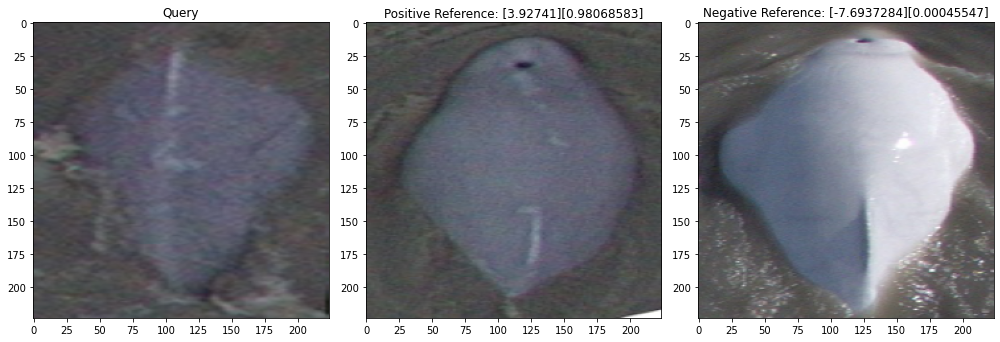

In [9]:
idx = 1
anchor, pos, neg = getImages(idx)
plotImages(anchor, pos, neg)

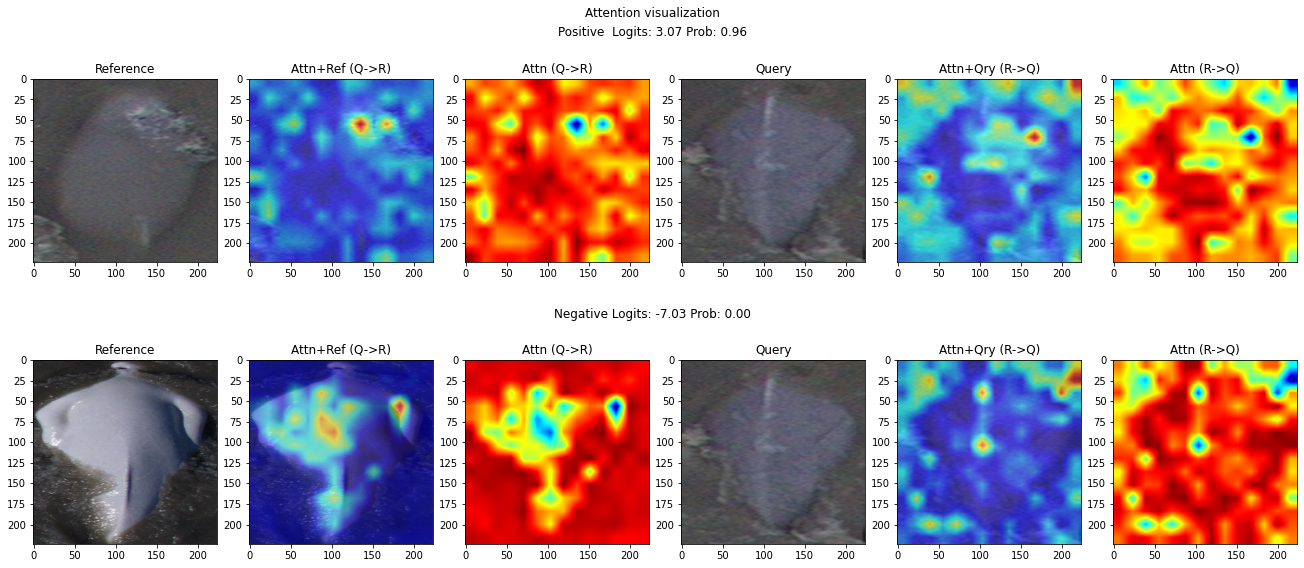

In [12]:
idx = 1
anchor, pos, neg = getImages(idx)
plotAttn(anchor, pos, neg)

In [83]:
logits, probs, attn = forward(anchor, pos, neg)
print(len(attn))
print(len(attn[0]))
print(len(attn[0][0]))
print(attn[0][0][0].shape)

3
2
2
torch.Size([2, 12, 1, 197])
